In [386]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [387]:
# read telescope_data

telescope_data = pd.read_csv("datasets/telescope_data.csv", index_col=0)
telescope_data = telescope_data.sample(frac=1).reset_index(drop=True)
telescope_data.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,92.7646,43.1607,3.8629,0.1694,0.0908,27.9134,48.6030,26.6269,0.9640,389.622,g
1,19.8412,16.7819,2.3128,0.4818,0.2993,14.3041,18.3897,-13.8364,13.1411,200.071,g
2,67.3022,14.3018,3.0689,0.3413,0.1856,6.7963,69.8929,-6.6490,2.3190,164.624,g
3,131.8510,32.4922,3.1075,0.2217,0.1144,-48.6616,-89.5004,-15.0075,4.3700,293.047,h
4,13.3106,10.3383,2.1658,0.7986,0.4676,13.6042,6.0074,11.4066,7.0350,163.036,g


In [388]:
# 1.data rebalancing
class_col = "class"
gamma = telescope_data[telescope_data[class_col] == 'g']
hadron_rows = telescope_data[class_col].value_counts().iloc[0] # number of hadron samples 6688
gamma_rows = telescope_data[class_col].value_counts().iloc[1]  # number of gamma samples 12332

telescope_data = telescope_data.drop(telescope_data[telescope_data[class_col].eq('g')].sample(hadron_rows - gamma_rows).index)

X = telescope_data.iloc[:,:-1]
y = telescope_data[class_col]

# Z-score Standardization
X_mean = X.mean()
X_std = X.std()
X_standardized = (X - X_mean) / X_std

telescope_data = pd.concat([X_standardized, y], axis=1)
display(X)
display(y)


,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
0,92.7646,43.1607,3.8629,0.1694,0.0908,27.9134,48.6030,26.6269,0.9640,389.6220
3,131.8510,32.4922,3.1075,0.2217,0.1144,-48.6616,-89.5004,-15.0075,4.3700,293.0470
5,254.0912,129.8571,3.5467,0.1239,0.0697,369.5594,-132.2893,111.7821,63.6941,68.6075
6,28.2691,19.8662,2.6762,0.3804,0.2212,27.8963,12.3808,12.0986,38.1192,64.8425
7,33.0473,18.5401,2.6875,0.4476,0.2659,30.3266,21.0689,16.3566,9.5992,168.6630
...,...,...,...,...,...,...,...,...,...,...
19010,117.9271,11.9790,2.4598,0.5066,0.2696,-95.0917,49.9629,-5.7808,1.9805,331.4114
19014,18.8654,12.9148,2.2881,0.6435,0.3639,8.8434,22.1641,8.4853,72.2904,45.4723
19016,79.8937,26.1386,3.2710,0.2282,0.1428,-62.0345,56.6200,-19.2490,34.9860,290.4310
19018,30.4807,21.9345,2.8594,0.3856,0.2080,18.3017,25.8472,-5.9511,7.2421,149.9830


0        g
3        h
5        h
6        h
7        g
        ..
19010    h
19014    h
19016    h
19018    g
19019    g
Name: class, Length: 13376, dtype: object

In [389]:
# 2.splitting data

total_rows = telescope_data.shape[0]

training_set_ratio = 0.7
validation_set_ratio = 0.15
test_set_ratio = 0.15

training_end = int(total_rows * training_set_ratio)
validation_end = int(total_rows * (training_set_ratio + validation_set_ratio))

training_set = telescope_data[:training_end]
validation_set = telescope_data[training_end:validation_end]
test_set = telescope_data[validation_end:]

# display(training_set)
# display(validation_set)
# display(test_set)

In [390]:
# 3.KNN Classifier Manually

from collections import Counter

class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X.to_numpy()
        self.y_train = y.to_numpy()

    def predict(self, X):
        X = X.to_numpy()
        predictions = [self._predict(x) for x in X]
        return np.array(predictions)

    def euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    def _predict(self, x):
        # compute the distance
        distances = [self.euclidean_distance(x, x_train) for x_train in self.X_train]
        # x -> [d1, d2, d3, .....]
        # get the closest k
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        # majority vote
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

X = training_set.iloc[:, :-1]
y = training_set[class_col]

classifier = KNN(k=25)
classifier.fit(X, y)
X_validation = validation_set.iloc[:, :-1]
predictions = classifier.predict(X_validation)

print(predictions)

['h' 'g' 'h' ... 'h' 'g' 'g']


Accuracy: 81.11%

Per-class metrics:
  Class  Precision    Recall  F1-score
0     g   0.780508  0.884726  0.829356
1     h   0.854722  0.731606  0.788386

Confusion Matrix:


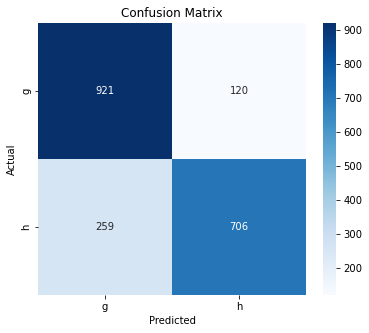

In [391]:
# classification evaluation

def evaluate_classification(y_target, y_predicted):
    
    y_target = np.array(y_target)
    y_predicted = np.array(y_predicted)

    # get classes
    classes = np.unique(np.concatenate((y_target, y_predicted)))

    # initialize confusion_matrix
    conf_matrix = np.zeros((len(classes), len(classes)), dtype=int)

    # fill confusion_matrix
    for i in range(len(y_target)):
        true_idx = np.where(classes == y_target[i])[0][0]
        pred_idx = np.where(classes == y_predicted[i])[0][0]
        conf_matrix[true_idx, pred_idx] += 1
    
    # per-class metrics
    precision = []
    recall = []
    f1 = []

    for i in range(len(classes)):
        TP = conf_matrix[i, i]
        FP = np.sum(conf_matrix[:, i]) - TP
        FN = np.sum(conf_matrix[i, :]) - TP

        prec = TP / (TP + FP) if (TP + FP) != 0 else 0
        rec = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1_score = (2 * prec * rec) / (prec + rec) if (prec + rec) != 0 else 0

        precision.append(prec)
        recall.append(rec)
        f1.append(f1_score)

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)

    # summarize results
    metrics_df = pd.DataFrame({
        'Class': classes,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    })

    return accuracy, metrics_df, conf_matrix

y_target = validation_set[class_col].to_numpy()
y_predicted = predictions
accuracy, metrics_df, conf_matrix = evaluate_classification(y_target,y_predicted)

print(f"Accuracy: {accuracy * 100:.2f}%\n")
print("Per-class metrics:")
print(metrics_df)
print("\nConfusion Matrix:")
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=metrics_df['Class'],
            yticklabels=metrics_df['Class'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [407]:
# Manual implementation final test
X_manual_test = test_set.iloc[:, :-1]
y_manual_test = test_set[class_col]

manual_test_prediction = classifier.predict(X_manual_test)

Accuracy: 81.17%

Per-class metrics:
  Class  Precision    Recall  F1-score
0     g   0.775773  0.885294  0.826923
1     h   0.861210  0.735562  0.793443

Confusion Matrix:


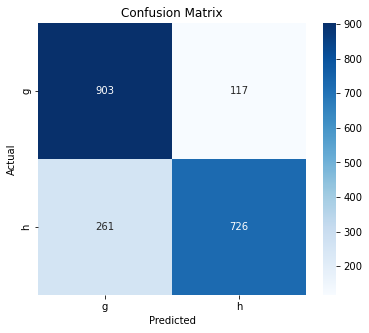

In [408]:

y_manual_test = y_manual_test.to_numpy()
accuracy, metrics_df, conf_matrix = evaluate_classification(y_manual_test,manual_test_prediction)

print(f"Accuracy: {accuracy * 100:.2f}%\n")
print("Per-class metrics:")
print(metrics_df)
print("\nConfusion Matrix:")
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=metrics_df['Class'],
            yticklabels=metrics_df['Class'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [393]:
# 4.KNN implementation using scikit-learn

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Separate features and target
X = telescope_data.iloc[:, :-1]
Y = telescope_data[class_col]

# Step 1: Split into training + temp (which will later be split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, Y, test_size=0.3, random_state=0
)

# Step 2: Split the temp data into validation and test sets equally (15% each)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=0
)

clf = KNeighborsClassifier(n_neighbors=25)
clf.fit(X_train, y_train)

,n_neighbors,25
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [394]:
y_val_pred = clf.predict(X_val)
print("validation set predictions: {}".format(y_val_pred))

validation set predictions: ['h' 'g' 'h' ... 'h' 'h' 'h']


In [395]:
print("validation set accuracy: {:.2f}%".format(clf.score(X_val, y_val) * 100))

validation set accuracy: 80.36%


Validation Accuracy: 80.36%

Classification Report:
              precision    recall  f1-score   support

           g       0.75      0.90      0.82       988
           h       0.88      0.71      0.79      1018

    accuracy                           0.80      2006
   macro avg       0.81      0.80      0.80      2006
weighted avg       0.82      0.80      0.80      2006



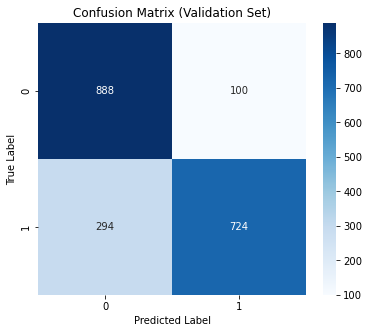

In [ ]:
# classification evaluation with scikit-learn

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%\n")

print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
conf_mat = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(6,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [403]:
# Final test
test_prediction = clf.predict(X_test)

Validation Accuracy: 79.92%

Classification Report:
              precision    recall  f1-score   support

           g       0.75      0.90      0.82      1005
           h       0.87      0.70      0.78      1002

    accuracy                           0.80      2007
   macro avg       0.81      0.80      0.80      2007
weighted avg       0.81      0.80      0.80      2007



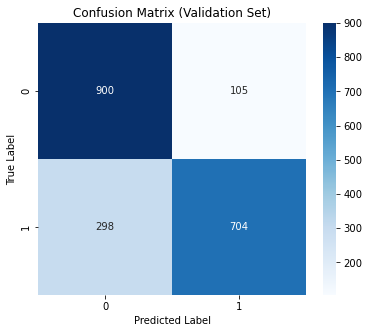

In [405]:
# classification evaluation with scikit-learn

accuracy = accuracy_score(y_test, test_prediction)
print(f"Validation Accuracy: {accuracy * 100:.2f}%\n")

print("Classification Report:")
print(classification_report(y_test, test_prediction))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, test_prediction)

plt.figure(figsize=(6,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()